In [1]:
import sys
import os
import warnings
import logging
import numpy as np
import pandas as pd
import random as rn
import imblearn

import sklearn
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib

from tensorflow.keras import backend as K

import helper_functions.config as config
import helper_functions.data_functions as data_functions
import helper_functions.plotting_functions as plotting_functions

# Note: tf 2.1.0 give warning about model weight format when
# using class weights. This is the only way to silence without
# updating

def warn(*args, **kwargs):
    pass

tf.get_logger().setLevel(logging.ERROR)
warnings.warn = warn

tf.random.set_seed(42)
np.random.seed(42)
rn.seed(42)

os.environ['PYTHONHASHSEED']=str(42)

print(f"Python {sys.version}")
print()
print(f"Pandas {pd.__version__}")
print(f"Tensorflow {tf.__version__}")
print(f"Keras {keras.__version__}")
print(f"SciKit Learn {sklearn.__version__}")
print(f"Imbalanced-Learn {imblearn.__version__}")
print()

devices = device_lib.list_local_devices()

if 'GPU' in ('').join(str(devices)):
    print("tf accessable GPU found: "+devices[-2].physical_device_desc)

Python 3.7.7 (default, Mar 23 2020, 22:36:06) 
[GCC 7.3.0]

Pandas 1.0.3
Tensorflow 2.2.0
Keras 2.3.0-tf
SciKit Learn 0.23.1
Imbalanced-Learn 0.7.0

tf accessable GPU found: device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1


In [2]:
def test_datasets(datasets, hyperparameters):
    history_list = []
    test_predictions_list = []
    train_predictions_list = []
    results_list = []

    # Load data
    for dataset in datasets.values():
        training_data = pd.read_parquet(dataset)

        # Dataset specific hyperparameters
        dataset_len = len(training_data)
        ignition_count = sum(training_data['ignition'])
        no_ignition_count = dataset_len - ignition_count

        initial_bias = np.log([ignition_count / no_ignition_count])
        output_bias = tf.keras.initializers.Constant(initial_bias)

        weight_for_0 = (1 / no_ignition_count)*(dataset_len)/2.0 
        weight_for_1 = (1 / ignition_count)*(dataset_len)/2.0

        class_weight = {0: weight_for_0, 1: weight_for_1}

        # Split labels and features.
        train_labels = training_data.pop('ignition')
        train_features = training_data

        # Make train, validation and test datasets
        X_train, X_test, y_train, y_test = train_test_split(
            train_features, 
            train_labels, 
            test_size=hyperparameters['test_data_fraction'], 
            stratify=train_labels, 
            random_state=hyperparameters['RAND_SEED']
        )
        
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, 
            y_train, 
            test_size=hyperparameters['validation_data_fraction'], 
            stratify=y_train, 
            random_state=hyperparameters['RAND_SEED']
        )
        
        X_train.drop(['raw_lat', 'raw_lon', 'date'], inplace=True, axis=1)
        X_val.drop(['raw_lat', 'raw_lon', 'date'], inplace=True, axis=1)
        X_test.drop(['raw_lat', 'raw_lon', 'date'], inplace=True, axis=1)
        
        STEPS_PER_EPOCH = int((len(y_train) * hyperparameters['data_coverage_fraction']) // hyperparameters['BATCH_SIZE'])
        
        if hyperparameters['verbose'] != 0:
            print()
            print(f'Dataset: {dataset}')
            print()
            print(f'{training_data.info()}')
            print()
            print('Training labels shape:', X_train.shape)
            print('Validation labels shape:', X_val.shape)
            print('Testing labels shape:', X_test.shape)
            print()
            print('Training features shape:', y_train.shape)
            print('Validation features shape:', y_val.shape)
            print('Testing features shape:', y_test.shape)

            print()
            print(f'Epochs: {hyperparameters["EPOCHS"]}')
            print(f'Steps per epoch: {STEPS_PER_EPOCH}')
            print(f'Batch size: {hyperparameters["BATCH_SIZE"]}')
            print()
            print(f'Class weights: {class_weight}')
            print()

        # Define the keras model
        model = keras.Sequential()

        # Add input layer
        model.add(keras.Input(shape=(X_train.shape[1],)))

        # Add fully connected hidden layers
        for i in range(hyperparameters['hidden_layers']):
            model.add(keras.layers.Dense(
                hyperparameters['neurons_per_layer'],
                bias_initializer=keras.initializers.VarianceScaling(
                    scale=1.0,
                    mode='fan_in', 
                    distribution='normal', 
                    seed=hyperparameters['RAND_SEED']
                ),
                kernel_regularizer=keras.regularizers.l2(hyperparameters['l2_lambda']),
                activation = 'relu')
            )

        # Add output layer
        model.add(keras.layers.Dense(
            1, 
            activation = 'sigmoid', 
            bias_initializer = output_bias
        ))

        model.compile(
            optimizer=keras.optimizers.Adam(lr=hyperparameters['learning_rate']),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=hyperparameters['metrics']
        )

        # Train model
        history = model.fit(
            X_train,
            y_train,
            shuffle=True,
            epochs=hyperparameters['EPOCHS'],
            batch_size=hyperparameters['BATCH_SIZE'],
            steps_per_epoch=STEPS_PER_EPOCH,
            callbacks = [hyperparameters['early_stopping']],
            class_weight=class_weight,
            validation_data = (X_val, y_val),
            verbose=hyperparameters['verbose']
        )

        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)

        results = model.evaluate(
            X_test,
            y_test, 
            verbose=hyperparameters['verbose']
        )

        history_list.append(history)
        test_predictions_list.append(test_predictions)
        train_predictions_list.append(train_predictions)
        results_list.append(results)
        
        K.clear_session()
        
    results = {'history_list': history_list,
            'test_predictions_list': test_predictions_list,
            'train_predictions_list': train_predictions_list,
            'results_list': results_list,
            'y_train': y_train,
            'y_test': y_test
    }
    
    return results

In [3]:
# model hyperparameters

hyperparameters = {
    'RAND_SEED': 42,
    'EPOCHS': 25,
    'BATCH_SIZE': (32 * 600),

    'data_coverage_fraction': 1.0,
    'test_data_fraction': 0.1,
    'validation_data_fraction': 0.5,

    'learning_rate': 0.001,
    'hidden_layers': 5,
    'neurons_per_layer': 10,
    'l2_lambda': 0.01,

    'metrics': [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        data_functions.matthews_correlation,
        data_functions.f1
    ],

    'early_stopping': tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        min_delta=0.01,
        verbose=1,
        patience=20,
        mode='min',
        restore_best_weights=True
    ),
    
    'verbose': 1
}

## Test 1: Scaling

In [4]:
# datasets for testing

datasets = {
    'Mean only: raw': '/mnt/SSD/data/training_data/1992-2015_california_raw_mean.parquet',
    'Mean only: (0, 1) scaled': '/mnt/SSD/data/training_data/1992-2015_california_min0_max1_scaled_mean.parquet',
    'Mean only: (-1, 1) scaled': '/mnt/SSD/data/training_data/1992-2015_california_min-1_max1_scaled_mean.parquet',
    'Mean only: z-score scaled': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean.parquet'
}

scaling_results = test_datasets(datasets, hyperparameters)


Dataset: /mnt/SSD/data/training_data/1992-2015_california_raw_mean.parquet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 18 columns):
 #   Column            Dtype         
---  ------            -----         
 0   lat               float32       
 1   lon               float32       
 2   month             int32         
 3   apcp              float32       
 4   crain             int32         
 5   veg               float32       
 6   mean_air_2m       float32       
 7   mean_rhum_2m      float32       
 8   mean_dpt_2m       float32       
 9   mean_pres_sfc     float32       
 10  mean_uwnd_10m     float32       
 11  mean_vwnd_10m     float32       
 12  mean_vis          float32       
 13  mean_cloud_cover  float32       
 14  total_fires       int32         
 15  raw_lat           float32       
 16  raw_lon           float32       
 17  date              datetime64[ns]
dtypes: datetime64[ns](1), float32(14), int32(3)
m

84/84 [==============================] - 2s 23ms/step - loss: 4.6116 - tp: 34575.0000 - fp: 570912.0000 - tn: 971996.0000 - fn: 20644.0000 - accuracy: 0.6298 - precision: 0.0571 - recall: 0.6261 - auc: 0.6544 - matthews_correlation: 0.1351 - f1: 0.1376 - val_loss: 8.3214 - val_tp: 54914.0000 - val_fp: 1347617.0000 - val_tn: 213831.0000 - val_fn: 965.0000 - val_accuracy: 0.1662 - val_precision: 0.0392 - val_recall: 0.9827 - val_auc: 0.6930 - val_matthews_correlation: 0.0644 - val_f1: 0.0753
Epoch 15/25
84/84 [==============================] - 2s 23ms/step - loss: 3.4508 - tp: 35484.0000 - fp: 552437.0000 - tn: 990323.0000 - fn: 19883.0000 - accuracy: 0.6419 - precision: 0.0604 - recall: 0.6409 - auc: 0.6754 - matthews_correlation: 0.1393 - f1: 0.1352 - val_loss: 11.6082 - val_tp: 55700.0000 - val_fp: 1491070.0000 - val_tn: 70378.0000 - val_fn: 179.0000 - val_accuracy: 0.0780 - val_precision: 0.0360 - val_recall: 0.9968 - val_auc: 0.6314 - val_matthews_correlation: 0.0374 - val_f1: 0.069

84/84 [==============================] - 2s 24ms/step - loss: 1.0044 - tp: 37791.0000 - fp: 483183.0000 - tn: 1059705.0000 - fn: 17448.0000 - accuracy: 0.6867 - precision: 0.0725 - recall: 0.6841 - auc: 0.7457 - matthews_correlation: 0.1498 - f1: 0.1369 - val_loss: 0.9381 - val_tp: 39102.0000 - val_fp: 393015.0000 - val_tn: 1168433.0000 - val_fn: 16777.0000 - val_accuracy: 0.7466 - val_precision: 0.0905 - val_recall: 0.6998 - val_auc: 0.7926 - val_matthews_correlation: 0.1849 - val_f1: 0.1602
Epoch 3/25
84/84 [==============================] - 2s 24ms/step - loss: 0.8879 - tp: 41277.0000 - fp: 433624.0000 - tn: 1109321.0000 - fn: 13905.0000 - accuracy: 0.7200 - precision: 0.0869 - recall: 0.7480 - auc: 0.8026 - matthews_correlation: 0.1865 - f1: 0.1558 - val_loss: 0.8430 - val_tp: 41646.0000 - val_fp: 423146.0000 - val_tn: 1138302.0000 - val_fn: 14233.0000 - val_accuracy: 0.7296 - val_precision: 0.0896 - val_recall: 0.7453 - val_auc: 0.8117 - val_matthews_correlation: 0.1912 - val_f1: 

84/84 [==============================] - 2s 24ms/step - loss: 0.5982 - tp: 42348.0000 - fp: 402366.0000 - tn: 1140436.0000 - fn: 12977.0000 - accuracy: 0.7401 - precision: 0.0952 - recall: 0.7654 - auc: 0.8282 - matthews_correlation: 0.2061 - f1: 0.1695 - val_loss: 0.5827 - val_tp: 41520.0000 - val_fp: 376486.0000 - val_tn: 1184962.0000 - val_fn: 14359.0000 - val_accuracy: 0.7583 - val_precision: 0.0993 - val_recall: 0.7430 - val_auc: 0.8301 - val_matthews_correlation: 0.2093 - val_f1: 0.1751
Epoch 19/25
84/84 [==============================] - 2s 24ms/step - loss: 0.5960 - tp: 42227.0000 - fp: 402733.0000 - tn: 1140110.0000 - fn: 13057.0000 - accuracy: 0.7398 - precision: 0.0949 - recall: 0.7638 - auc: 0.8278 - matthews_correlation: 0.2050 - f1: 0.1690 - val_loss: 0.6323 - val_tp: 44520.0000 - val_fp: 447357.0000 - val_tn: 1114091.0000 - val_fn: 11359.0000 - val_accuracy: 0.7164 - val_precision: 0.0905 - val_recall: 0.7967 - val_auc: 0.8301 - val_matthews_correlation: 0.2025 - val_f1:

Epoch 6/25
84/84 [==============================] - 2s 23ms/step - loss: 0.6747 - tp: 42007.0000 - fp: 403755.0000 - tn: 1139208.0000 - fn: 13157.0000 - accuracy: 0.7391 - precision: 0.0942 - recall: 0.7615 - auc: 0.8264 - matthews_correlation: 0.2034 - f1: 0.1678 - val_loss: 0.6748 - val_tp: 42702.0000 - val_fp: 409348.0000 - val_tn: 1152100.0000 - val_fn: 13177.0000 - val_accuracy: 0.7388 - val_precision: 0.0945 - val_recall: 0.7642 - val_auc: 0.8287 - val_matthews_correlation: 0.2042 - val_f1: 0.1680
Epoch 7/25
84/84 [==============================] - 2s 24ms/step - loss: 0.6513 - tp: 42206.0000 - fp: 401601.0000 - tn: 1141178.0000 - fn: 13142.0000 - accuracy: 0.7405 - precision: 0.0951 - recall: 0.7626 - auc: 0.8279 - matthews_correlation: 0.2052 - f1: 0.1692 - val_loss: 0.6603 - val_tp: 43200.0000 - val_fp: 418804.0000 - val_tn: 1142644.0000 - val_fn: 12679.0000 - val_accuracy: 0.7332 - val_precision: 0.0935 - val_recall: 0.7731 - val_auc: 0.8293 - val_matthews_correlation: 0.2040

84/84 [==============================] - 2s 24ms/step - loss: 0.5744 - tp: 42631.0000 - fp: 402783.0000 - tn: 1140145.0000 - fn: 12568.0000 - accuracy: 0.7401 - precision: 0.0957 - recall: 0.7723 - auc: 0.8325 - matthews_correlation: 0.2083 - f1: 0.1704 - val_loss: 0.5669 - val_tp: 42497.0000 - val_fp: 386315.0000 - val_tn: 1175133.0000 - val_fn: 13382.0000 - val_accuracy: 0.7529 - val_precision: 0.0991 - val_recall: 0.7605 - val_auc: 0.8348 - val_matthews_correlation: 0.2121 - val_f1: 0.1752
Epoch 23/25
84/84 [==============================] - 2s 24ms/step - loss: 0.5731 - tp: 42996.0000 - fp: 400733.0000 - tn: 1141967.0000 - fn: 12431.0000 - accuracy: 0.7415 - precision: 0.0969 - recall: 0.7757 - auc: 0.8339 - matthews_correlation: 0.2109 - f1: 0.1724 - val_loss: 0.5806 - val_tp: 43378.0000 - val_fp: 405253.0000 - val_tn: 1156195.0000 - val_fn: 12501.0000 - val_accuracy: 0.7417 - val_precision: 0.0967 - val_recall: 0.7763 - val_auc: 0.8353 - val_matthews_correlation: 0.2106 - val_f1:

Epoch 10/25
84/84 [==============================] - 2s 23ms/step - loss: 0.5802 - tp: 43116.0000 - fp: 408599.0000 - tn: 1134209.0000 - fn: 12203.0000 - accuracy: 0.7367 - precision: 0.0954 - recall: 0.7794 - auc: 0.8334 - matthews_correlation: 0.2090 - f1: 0.1702 - val_loss: 0.5788 - val_tp: 43607.0000 - val_fp: 409321.0000 - val_tn: 1152127.0000 - val_fn: 12272.0000 - val_accuracy: 0.7393 - val_precision: 0.0963 - val_recall: 0.7804 - val_auc: 0.8356 - val_matthews_correlation: 0.2107 - val_f1: 0.1713
Epoch 11/25
84/84 [==============================] - 2s 24ms/step - loss: 0.5726 - tp: 43043.0000 - fp: 408100.0000 - tn: 1134847.0000 - fn: 12137.0000 - accuracy: 0.7370 - precision: 0.0954 - recall: 0.7800 - auc: 0.8345 - matthews_correlation: 0.2096 - f1: 0.1704 - val_loss: 0.5823 - val_tp: 44130.0000 - val_fp: 419952.0000 - val_tn: 1141496.0000 - val_fn: 11749.0000 - val_accuracy: 0.7331 - val_precision: 0.0951 - val_recall: 0.7897 - val_auc: 0.8362 - val_matthews_correlation: 0.21

11232/11232 [==============================] - 75s 7ms/step - loss: 0.5425 - tp: 9715.0000 - fp: 88811.0000 - tn: 258177.0000 - fn: 2703.0000 - accuracy: 0.7454 - precision: 0.0986 - recall: 0.7823 - auc: 0.8400 - matthews_correlation: 0.1723 - f1: 0.1598


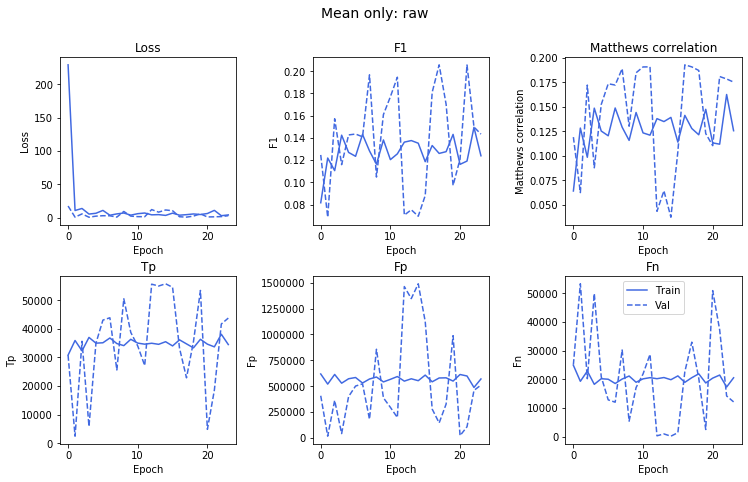

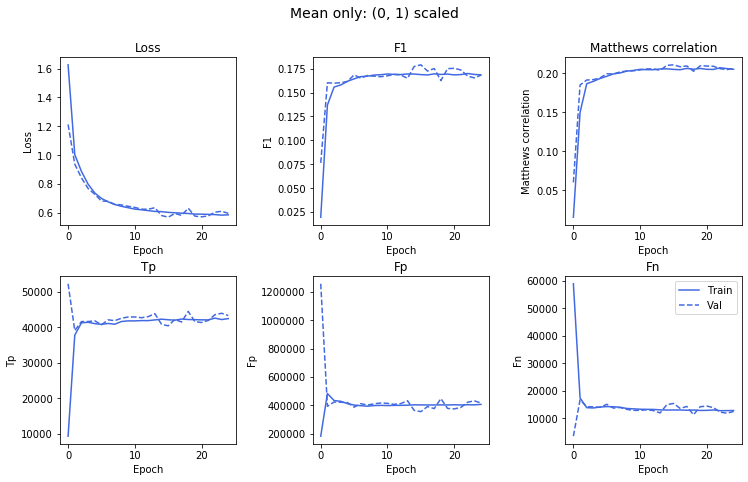

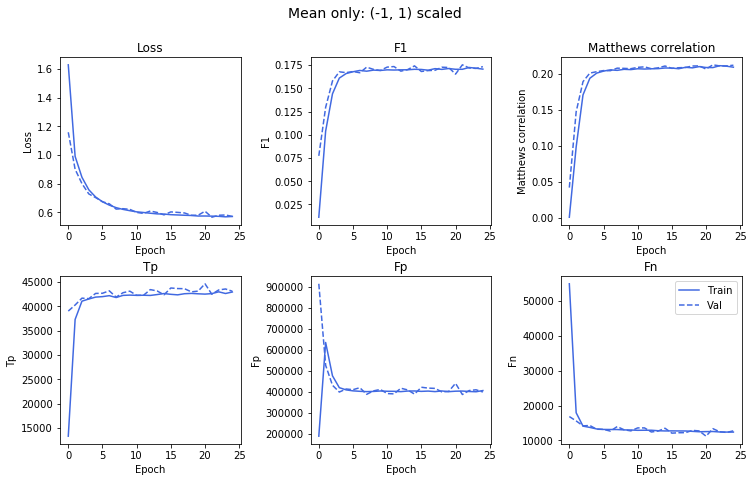

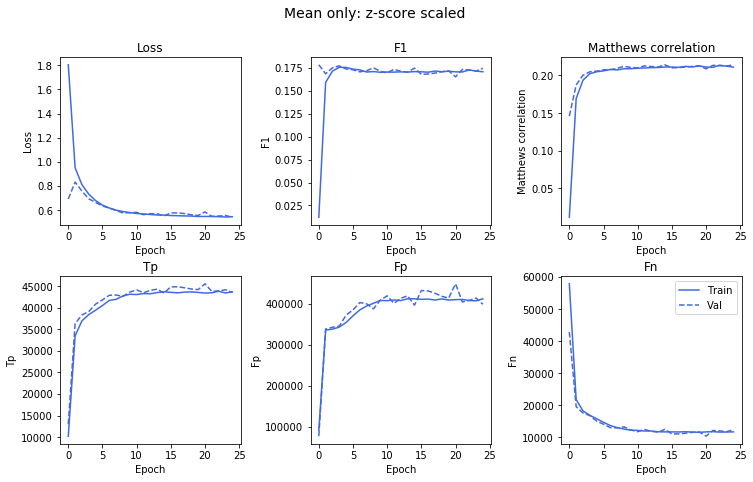

In [5]:
metric_names =  ['loss', 'f1', 'matthews_correlation', 'tp', 'fp', 'fn']
filename = '../project_info/figures/feature_engineering_test_learning_curves.png'

history_list = scaling_results['history_list']

for history, dataset in zip(history_list, datasets.keys()):
    plotting_functions.plot_metrics(dataset, history, metric_names, filename)

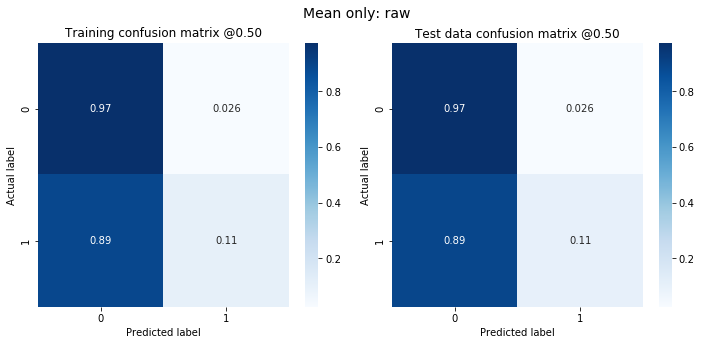

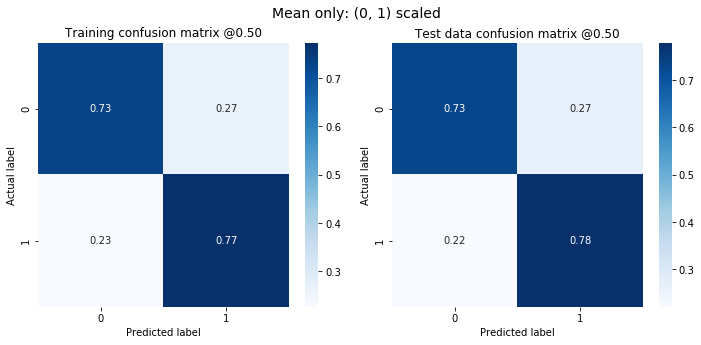

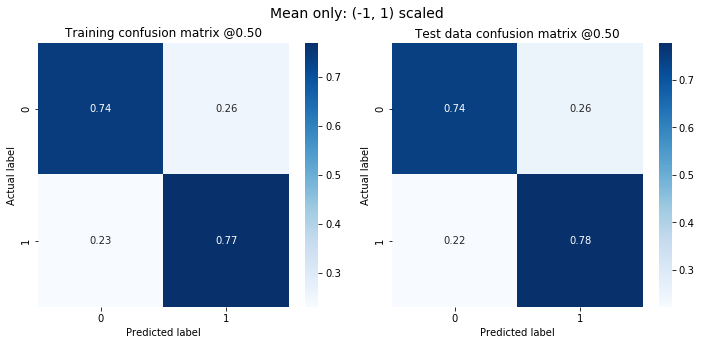

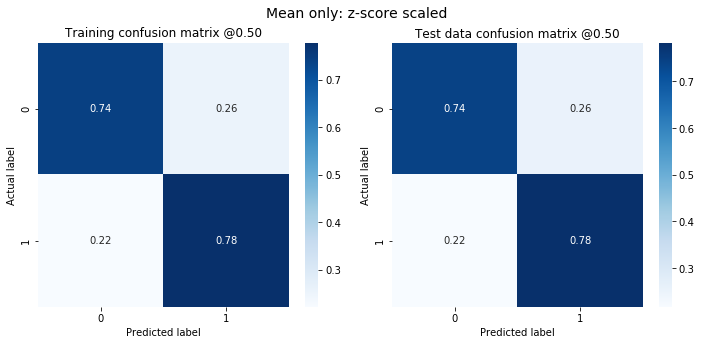

In [6]:
filename = '../project_info/figures/feature_engineering_test_learning_curves.png'

train_predictions_list = scaling_results['train_predictions_list']
test_predictions_list = scaling_results['test_predictions_list']

y_train = scaling_results['y_train']
y_test = scaling_results['y_test']

for train_predictions, test_predictions, title in zip(train_predictions_list, test_predictions_list, datasets.keys()):
    plotting_functions.plot_multiple_CMs(y_train, train_predictions, y_test, test_predictions, title, filename)

## Test 2: Box-Cox quantile transformation

In [7]:
# datasets for testing

datasets = {
    'Mean only: z-score scaled': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean.parquet',
    'Mean only: z-score scaled, selective Box-Cox': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_selective_box_cox.parquet',
    'Mean only: z-score scaled, full Box-Cox': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_full_box_cox.parquet'
}

boxcox_results = test_datasets(datasets, hyperparameters)


Dataset: /mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean.parquet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 18 columns):
 #   Column            Dtype         
---  ------            -----         
 0   lat               float32       
 1   lon               float32       
 2   month             float32       
 3   apcp              float32       
 4   crain             int32         
 5   veg               float32       
 6   mean_air_2m       float32       
 7   mean_rhum_2m      float32       
 8   mean_dpt_2m       float32       
 9   mean_pres_sfc     float32       
 10  mean_uwnd_10m     float32       
 11  mean_vwnd_10m     float32       
 12  mean_vis          float32       
 13  mean_cloud_cover  float32       
 14  total_fires       float32       
 15  raw_lat           float32       
 16  raw_lon           float32       
 17  date              datetime64[ns]
dtypes: datetime64[ns](1), float32(16)

84/84 [==============================] - 2s 23ms/step - loss: 0.5759 - tp: 42078.0000 - fp: 395186.0000 - tn: 1147722.0000 - fn: 13141.0000 - accuracy: 0.7445 - precision: 0.0962 - recall: 0.7620 - auc: 0.8306 - matthews_correlation: 0.2073 - f1: 0.1711 - val_loss: 0.5865 - val_tp: 42998.0000 - val_fp: 403068.0000 - val_tn: 1158380.0000 - val_fn: 12881.0000 - val_accuracy: 0.7428 - val_precision: 0.0964 - val_recall: 0.7695 - val_auc: 0.8321 - val_matthews_correlation: 0.2089 - val_f1: 0.1712
Epoch 15/25
84/84 [==============================] - 2s 23ms/step - loss: 0.5755 - tp: 42467.0000 - fp: 399075.0000 - tn: 1143685.0000 - fn: 12900.0000 - accuracy: 0.7422 - precision: 0.0962 - recall: 0.7670 - auc: 0.8299 - matthews_correlation: 0.2081 - f1: 0.1711 - val_loss: 0.5649 - val_tp: 41940.0000 - val_fp: 378600.0000 - val_tn: 1182848.0000 - val_fn: 13939.0000 - val_accuracy: 0.7573 - val_precision: 0.0997 - val_recall: 0.7506 - val_auc: 0.8325 - val_matthews_correlation: 0.2114 - val_f1:

84/84 [==============================] - 2s 23ms/step - loss: 0.6761 - tp: 42237.0000 - fp: 383917.0000 - tn: 1159003.0000 - fn: 12970.0000 - accuracy: 0.7517 - precision: 0.0991 - recall: 0.7651 - auc: 0.8379 - matthews_correlation: 0.2131 - f1: 0.1755 - val_loss: 0.6763 - val_tp: 43652.0000 - val_fp: 399264.0000 - val_tn: 1162184.0000 - val_fn: 12227.0000 - val_accuracy: 0.7456 - val_precision: 0.0986 - val_recall: 0.7812 - val_auc: 0.8403 - val_matthews_correlation: 0.2152 - val_f1: 0.1750
Epoch 6/25
84/84 [==============================] - 2s 23ms/step - loss: 0.6421 - tp: 42738.0000 - fp: 390779.0000 - tn: 1152184.0000 - fn: 12426.0000 - accuracy: 0.7477 - precision: 0.0986 - recall: 0.7747 - auc: 0.8397 - matthews_correlation: 0.2139 - f1: 0.1748 - val_loss: 0.6450 - val_tp: 43717.0000 - val_fp: 397743.0000 - val_tn: 1163705.0000 - val_fn: 12162.0000 - val_accuracy: 0.7466 - val_precision: 0.0990 - val_recall: 0.7824 - val_auc: 0.8415 - val_matthews_correlation: 0.2163 - val_f1: 

84/84 [==============================] - 2s 23ms/step - loss: 0.5446 - tp: 43612.0000 - fp: 408348.0000 - tn: 1134716.0000 - fn: 11451.0000 - accuracy: 0.7373 - precision: 0.0965 - recall: 0.7920 - auc: 0.8413 - matthews_correlation: 0.2137 - f1: 0.1722 - val_loss: 0.5825 - val_tp: 45417.0000 - val_fp: 437651.0000 - val_tn: 1123797.0000 - val_fn: 10462.0000 - val_accuracy: 0.7229 - val_precision: 0.0940 - val_recall: 0.8128 - val_auc: 0.8435 - val_matthews_correlation: 0.2124 - val_f1: 0.1684
Epoch 22/25
84/84 [==============================] - 2s 23ms/step - loss: 0.5438 - tp: 43704.0000 - fp: 409908.0000 - tn: 1133020.0000 - fn: 11495.0000 - accuracy: 0.7363 - precision: 0.0963 - recall: 0.7918 - auc: 0.8414 - matthews_correlation: 0.2131 - f1: 0.1718 - val_loss: 0.5524 - val_tp: 44240.0000 - val_fp: 406436.0000 - val_tn: 1155012.0000 - val_fn: 11639.0000 - val_accuracy: 0.7415 - val_precision: 0.0982 - val_recall: 0.7917 - val_auc: 0.8435 - val_matthews_correlation: 0.2163 - val_f1:

Epoch 9/25
84/84 [==============================] - 2s 24ms/step - loss: 0.6148 - tp: 43757.0000 - fp: 412581.0000 - tn: 1130257.0000 - fn: 11532.0000 - accuracy: 0.7346 - precision: 0.0959 - recall: 0.7914 - auc: 0.8403 - matthews_correlation: 0.2120 - f1: 0.1710 - val_loss: 0.6121 - val_tp: 43922.0000 - val_fp: 406146.0000 - val_tn: 1155302.0000 - val_fn: 11957.0000 - val_accuracy: 0.7415 - val_precision: 0.0976 - val_recall: 0.7860 - val_auc: 0.8420 - val_matthews_correlation: 0.2143 - val_f1: 0.1736
Epoch 10/25
84/84 [==============================] - 2s 23ms/step - loss: 0.6012 - tp: 43804.0000 - fp: 413557.0000 - tn: 1129251.0000 - fn: 11515.0000 - accuracy: 0.7340 - precision: 0.0958 - recall: 0.7918 - auc: 0.8405 - matthews_correlation: 0.2119 - f1: 0.1710 - val_loss: 0.6062 - val_tp: 44360.0000 - val_fp: 416101.0000 - val_tn: 1145347.0000 - val_fn: 11519.0000 - val_accuracy: 0.7356 - val_precision: 0.0963 - val_recall: 0.7939 - val_auc: 0.8420 - val_matthews_correlation: 0.213

11232/11232 [==============================] - 77s 7ms/step - loss: 0.5387 - tp: 9752.0000 - fp: 89434.0000 - tn: 257554.0000 - fn: 2666.0000 - accuracy: 0.7437 - precision: 0.0983 - recall: 0.7853 - auc: 0.8429 - matthews_correlation: 0.1722 - f1: 0.1595


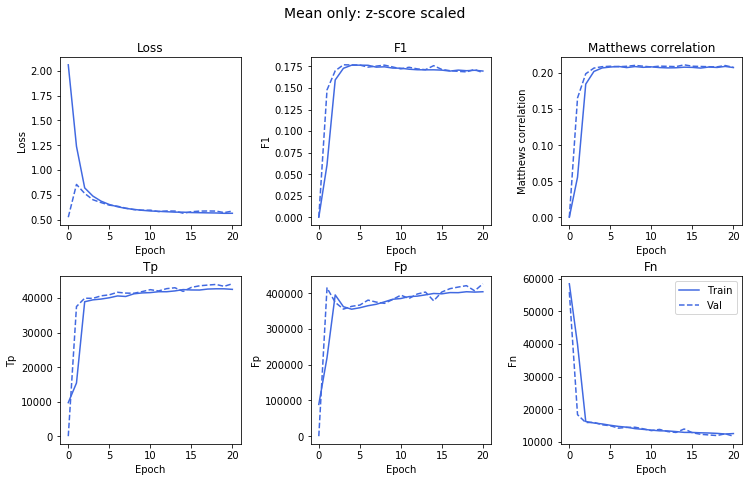

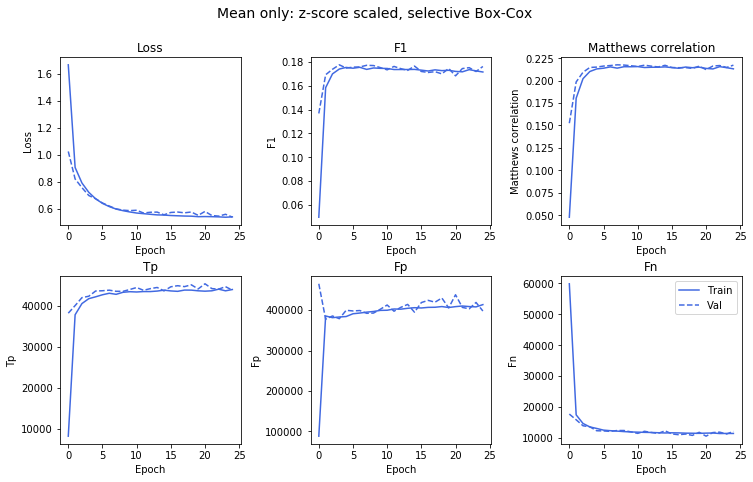

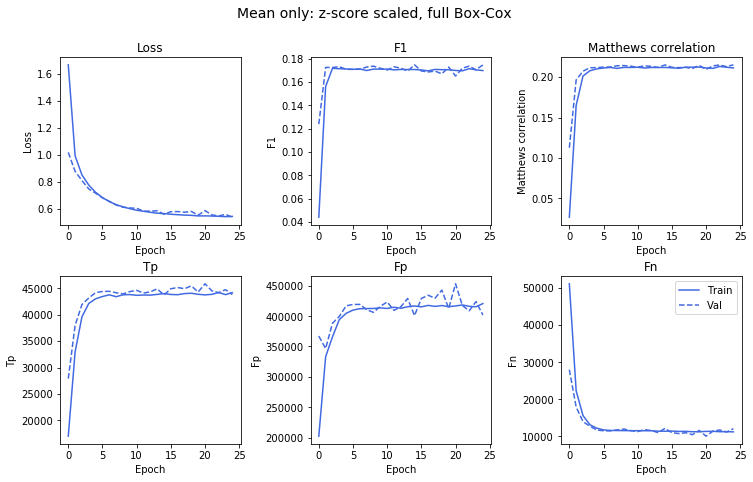

In [8]:
metric_names =  ['loss', 'f1', 'matthews_correlation', 'tp', 'fp', 'fn']
filename = '../project_info/figures/feature_engineering_test_learning_curves.png'

history_list = boxcox_results['history_list']

for history, dataset in zip(history_list, datasets.keys()):
    plotting_functions.plot_metrics(dataset, history, metric_names, filename)

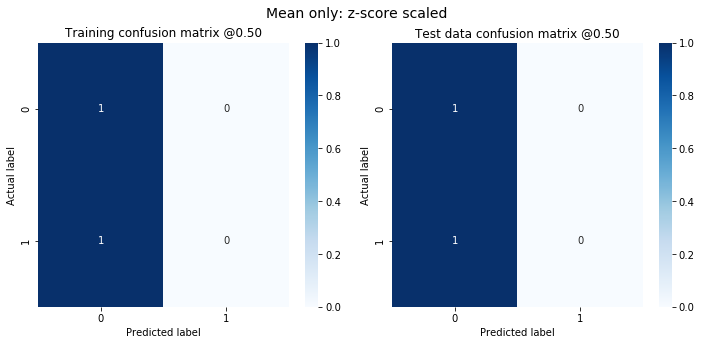

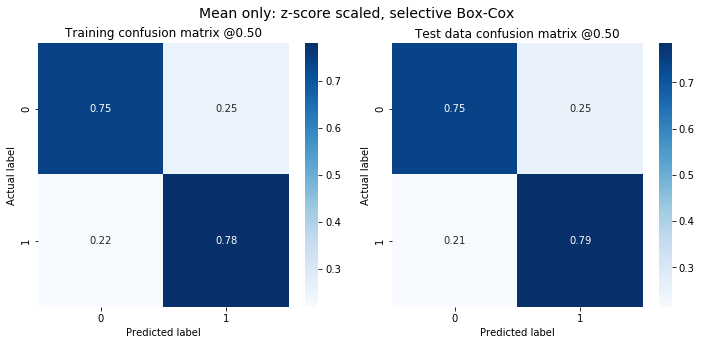

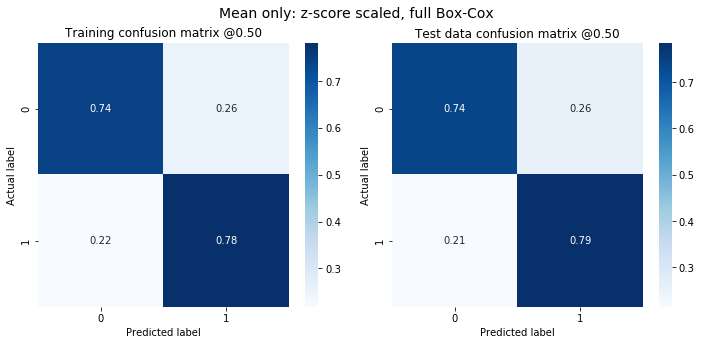

In [9]:
filename = '../project_info/figures/feature_engineering_test_learning_curves.png'

train_predictions_list = boxcox_results['train_predictions_list']
test_predictions_list = boxcox_results['test_predictions_list']

y_train = boxcox_results['y_train']
y_test = boxcox_results['y_test']

for train_predictions, test_predictions, title in zip(train_predictions_list, test_predictions_list, datasets.keys()):
    plotting_functions.plot_multiple_CMs(y_train, train_predictions, y_test, test_predictions, title, filename)

## Test 3: Min, max, range feature addition

In [10]:
# datasets for testing

datasets = {
    'Mean only: z-score scaled, selective Box-Cox': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_selective_box_cox.parquet',
    'Mean, absolute min, max: z-score scaled, selective Box-Cox': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_abs_min_max_selective_box_cox.parquet',
    'Mean, plus-minus min, max: z-score scaled, selective Box-Cox': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_plus-minus_min_max_selective_box_cox.parquet',
    'Mean, range: z-score scaled, selective Box-Cox': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_selective_box_cox.parquet'
}

min_max_results = test_datasets(datasets, hyperparameters)


Dataset: /mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_selective_box_cox.parquet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 18 columns):
 #   Column            Dtype         
---  ------            -----         
 0   lat               float32       
 1   lon               float32       
 2   month             float32       
 3   apcp              float32       
 4   crain             int32         
 5   veg               float32       
 6   mean_air_2m       float32       
 7   mean_rhum_2m      float32       
 8   mean_dpt_2m       float32       
 9   mean_pres_sfc     float32       
 10  mean_uwnd_10m     float32       
 11  mean_vwnd_10m     float32       
 12  mean_vis          float32       
 13  mean_cloud_cover  float32       
 14  total_fires       float32       
 15  raw_lat           float32       
 16  raw_lon           float32       
 17  date              datetime64[ns]
dtypes: datetime64[n

84/84 [==============================] - 2s 24ms/step - loss: 0.5519 - tp: 44165.0000 - fp: 422481.0000 - tn: 1120427.0000 - fn: 11054.0000 - accuracy: 0.7287 - precision: 0.0946 - recall: 0.7998 - auc: 0.8407 - matthews_correlation: 0.2116 - f1: 0.1696 - val_loss: 0.5649 - val_tp: 44925.0000 - val_fp: 428612.0000 - val_tn: 1132836.0000 - val_fn: 10954.0000 - val_accuracy: 0.7282 - val_precision: 0.0949 - val_recall: 0.8040 - val_auc: 0.8419 - val_matthews_correlation: 0.2125 - val_f1: 0.1697
Epoch 15/25
84/84 [==============================] - 2s 24ms/step - loss: 0.5509 - tp: 44305.0000 - fp: 421700.0000 - tn: 1121060.0000 - fn: 11062.0000 - accuracy: 0.7292 - precision: 0.0951 - recall: 0.8002 - auc: 0.8403 - matthews_correlation: 0.2122 - f1: 0.1702 - val_loss: 0.5501 - val_tp: 44206.0000 - val_fp: 410845.0000 - val_tn: 1150603.0000 - val_fn: 11673.0000 - val_accuracy: 0.7388 - val_precision: 0.0971 - val_recall: 0.7911 - val_auc: 0.8421 - val_matthews_correlation: 0.2144 - val_f1:

Epoch 1/25
84/84 [==============================] - 4s 43ms/step - loss: 2.1155 - tp: 9920.0000 - fp: 93041.0000 - tn: 1811020.0000 - fn: 58225.0000 - accuracy: 0.9233 - precision: 0.0963 - recall: 0.1456 - auc: 0.5231 - matthews_correlation: 0.0000e+00 - f1: 0.0000e+00 - val_loss: 0.5490 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1561448.0000 - val_fn: 55879.0000 - val_accuracy: 0.9654 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6006 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/25
84/84 [==============================] - 3s 32ms/step - loss: 1.2365 - tp: 18607.0000 - fp: 229301.0000 - tn: 1313587.0000 - fn: 36632.0000 - accuracy: 0.8336 - precision: 0.0751 - recall: 0.3368 - auc: 0.6269 - matthews_correlation: 0.0807 - f1: 0.0851 - val_loss: 0.8605 - val_tp: 34610.0000 - val_fp: 396835.0000 - val_tn: 1164613.0000 - val_fn: 21269.0000 - val_accuracy: 0.7415 - val_precision: 0.0802 - val_recall: 0.6194 - val_auc: 0.7493 - val_matthew

84/84 [==============================] - 3s 32ms/step - loss: 0.5503 - tp: 43801.0000 - fp: 406215.0000 - tn: 1136812.0000 - fn: 11299.0000 - accuracy: 0.7387 - precision: 0.0973 - recall: 0.7949 - auc: 0.8438 - matthews_correlation: 0.2156 - f1: 0.1734 - val_loss: 0.5783 - val_tp: 45238.0000 - val_fp: 422254.0000 - val_tn: 1139194.0000 - val_fn: 10641.0000 - val_accuracy: 0.7323 - val_precision: 0.0968 - val_recall: 0.8096 - val_auc: 0.8459 - val_matthews_correlation: 0.2171 - val_f1: 0.1728
Epoch 18/25
84/84 [==============================] - 3s 31ms/step - loss: 0.5484 - tp: 44074.0000 - fp: 405261.0000 - tn: 1137541.0000 - fn: 11251.0000 - accuracy: 0.7394 - precision: 0.0981 - recall: 0.7966 - auc: 0.8448 - matthews_correlation: 0.2172 - f1: 0.1747 - val_loss: 0.5709 - val_tp: 44858.0000 - val_fp: 413593.0000 - val_tn: 1147855.0000 - val_fn: 11021.0000 - val_accuracy: 0.7375 - val_precision: 0.0978 - val_recall: 0.8028 - val_auc: 0.8459 - val_matthews_correlation: 0.2179 - val_f1:

Epoch 7/25
84/84 [==============================] - 3s 32ms/step - loss: 0.6168 - tp: 43516.0000 - fp: 399614.0000 - tn: 1143165.0000 - fn: 11832.0000 - accuracy: 0.7425 - precision: 0.0982 - recall: 0.7862 - auc: 0.8421 - matthews_correlation: 0.2154 - f1: 0.1746 - val_loss: 0.6204 - val_tp: 44102.0000 - val_fp: 403894.0000 - val_tn: 1157554.0000 - val_fn: 11777.0000 - val_accuracy: 0.7430 - val_precision: 0.0984 - val_recall: 0.7892 - val_auc: 0.8435 - val_matthews_correlation: 0.2163 - val_f1: 0.1749
Epoch 8/25
84/84 [==============================] - 3s 32ms/step - loss: 0.5990 - tp: 43297.0000 - fp: 403087.0000 - tn: 1140088.0000 - fn: 11655.0000 - accuracy: 0.7405 - precision: 0.0970 - recall: 0.7879 - auc: 0.8417 - matthews_correlation: 0.2139 - f1: 0.1726 - val_loss: 0.6018 - val_tp: 44103.0000 - val_fp: 402401.0000 - val_tn: 1159047.0000 - val_fn: 11776.0000 - val_accuracy: 0.7439 - val_precision: 0.0988 - val_recall: 0.7893 - val_auc: 0.8439 - val_matthews_correlation: 0.2170

84/84 [==============================] - 3s 32ms/step - loss: 0.5382 - tp: 44579.0000 - fp: 413488.0000 - tn: 1129212.0000 - fn: 10848.0000 - accuracy: 0.7345 - precision: 0.0973 - recall: 0.8043 - auc: 0.8451 - matthews_correlation: 0.2171 - f1: 0.1737 - val_loss: 0.5434 - val_tp: 44797.0000 - val_fp: 410617.0000 - val_tn: 1150831.0000 - val_fn: 11082.0000 - val_accuracy: 0.7393 - val_precision: 0.0984 - val_recall: 0.8017 - val_auc: 0.8461 - val_matthews_correlation: 0.2186 - val_f1: 0.1751
Epoch 24/25
84/84 [==============================] - 3s 32ms/step - loss: 0.5359 - tp: 44213.0000 - fp: 413083.0000 - tn: 1129992.0000 - fn: 10839.0000 - accuracy: 0.7347 - precision: 0.0967 - recall: 0.8031 - auc: 0.8449 - matthews_correlation: 0.2161 - f1: 0.1726 - val_loss: 0.5513 - val_tp: 45145.0000 - val_fp: 418978.0000 - val_tn: 1142470.0000 - val_fn: 10734.0000 - val_accuracy: 0.7343 - val_precision: 0.0973 - val_recall: 0.8079 - val_auc: 0.8460 - val_matthews_correlation: 0.2177 - val_f1:

84/84 [==============================] - 2s 28ms/step - loss: 0.5728 - tp: 43860.0000 - fp: 403836.0000 - tn: 1138972.0000 - fn: 11459.0000 - accuracy: 0.7401 - precision: 0.0980 - recall: 0.7929 - auc: 0.8427 - matthews_correlation: 0.2163 - f1: 0.1745 - val_loss: 0.5815 - val_tp: 44382.0000 - val_fp: 406052.0000 - val_tn: 1155396.0000 - val_fn: 11497.0000 - val_accuracy: 0.7418 - val_precision: 0.0985 - val_recall: 0.7943 - val_auc: 0.8443 - val_matthews_correlation: 0.2176 - val_f1: 0.1753
Epoch 11/25
84/84 [==============================] - 2s 28ms/step - loss: 0.5645 - tp: 43768.0000 - fp: 404511.0000 - tn: 1138436.0000 - fn: 11412.0000 - accuracy: 0.7397 - precision: 0.0976 - recall: 0.7932 - auc: 0.8430 - matthews_correlation: 0.2162 - f1: 0.1742 - val_loss: 0.5839 - val_tp: 44804.0000 - val_fp: 415878.0000 - val_tn: 1145570.0000 - val_fn: 11075.0000 - val_accuracy: 0.7360 - val_precision: 0.0973 - val_recall: 0.8018 - val_auc: 0.8443 - val_matthews_correlation: 0.2166 - val_f1:

11232/11232 [==============================] - 75s 7ms/step - loss: 0.5392 - tp: 9852.0000 - fp: 90278.0000 - tn: 256710.0000 - fn: 2566.0000 - accuracy: 0.7417 - precision: 0.0984 - recall: 0.7934 - auc: 0.8454 - matthews_correlation: 0.1736 - f1: 0.1600


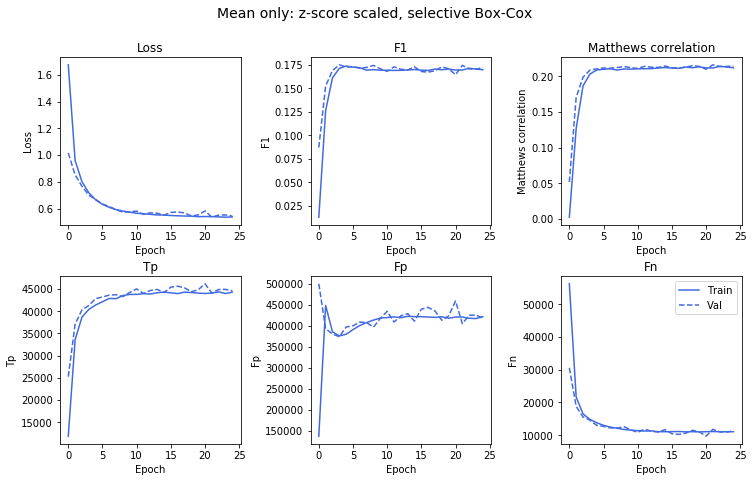

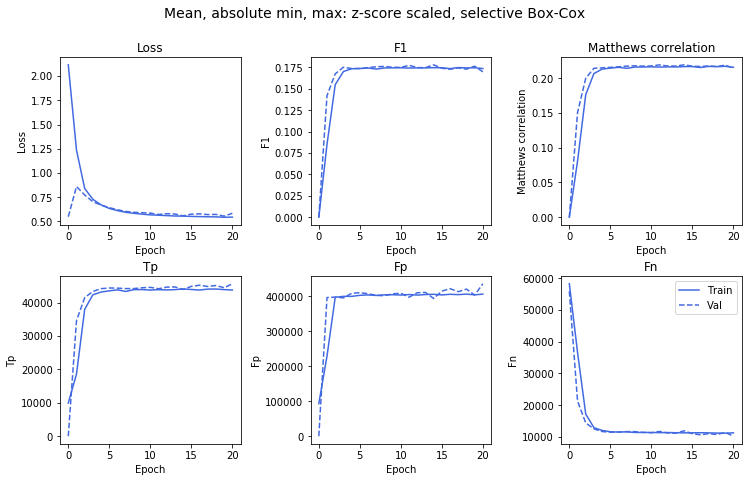

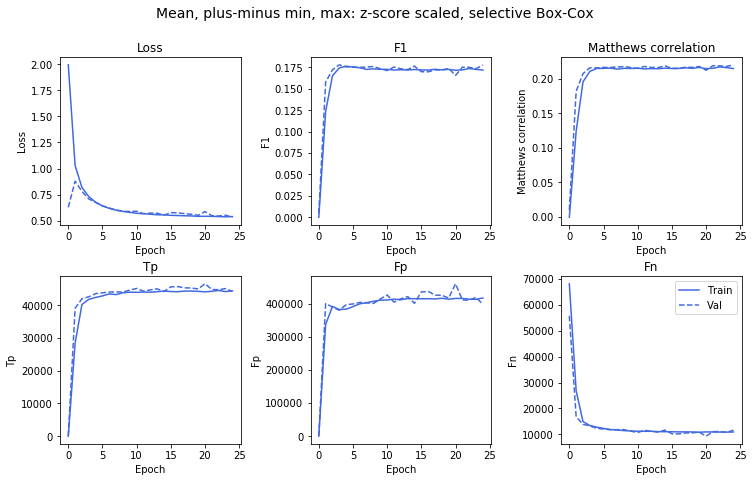

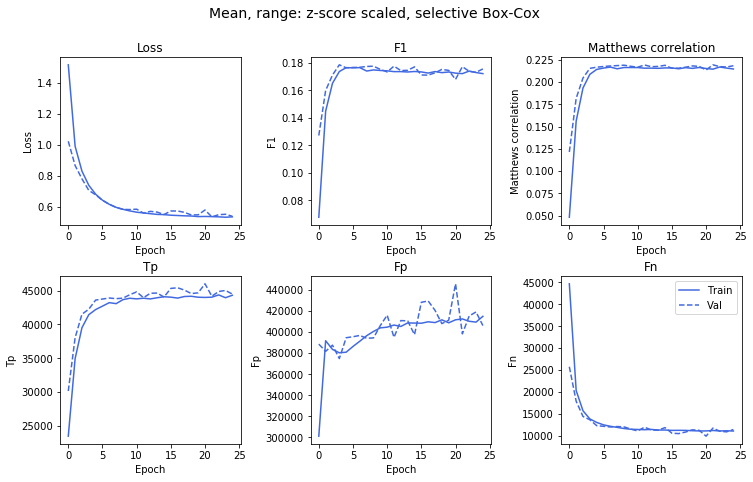

In [11]:
metric_names =  ['loss', 'f1', 'matthews_correlation', 'tp', 'fp', 'fn']
filename = '../project_info/figures/feature_engineering_test_learning_curves.png'

history_list = min_max_results['history_list']

for history, dataset in zip(history_list, datasets.keys()):
    plotting_functions.plot_metrics(dataset, history, metric_names, filename)

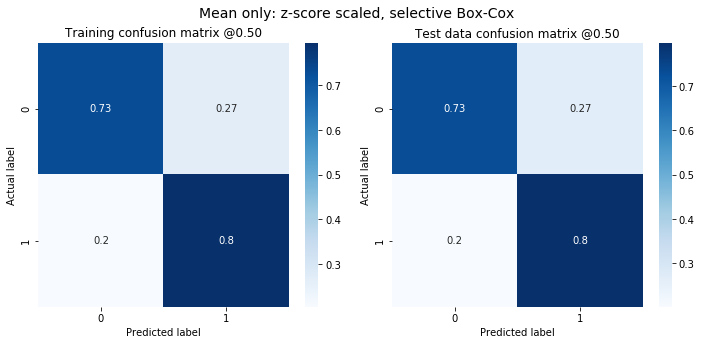

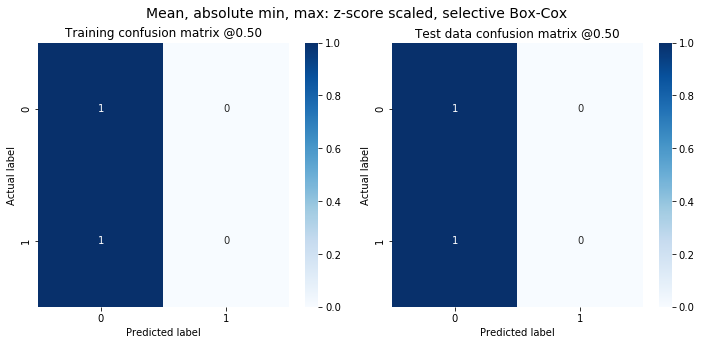

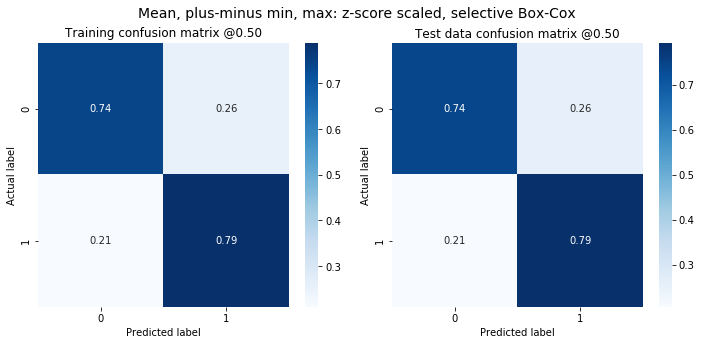

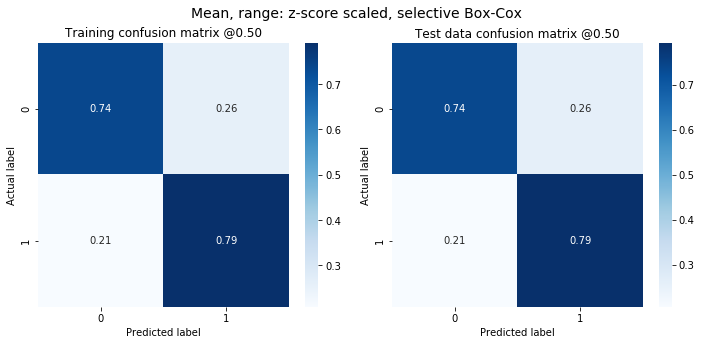

In [12]:
filename = '../project_info/figures/feature_engineering_test_learning_curves.png'

train_predictions_list = min_max_results['train_predictions_list']
test_predictions_list = min_max_results['test_predictions_list']

y_train = min_max_results['y_train']
y_test = min_max_results['y_test']

for train_predictions, test_predictions, title in zip(train_predictions_list, test_predictions_list, datasets.keys()):
    plotting_functions.plot_multiple_CMs(y_train, train_predictions, y_test, test_predictions, title, filename)

## Test 4: Month encoding

In [ ]:
# datasets for testing

datasets = {
    'Mean, range: z-score scaled, selective Box-Cox': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_selective_box_cox.parquet',
    'Mean, range, onehot month: z-score scaled, selective Box-Cox': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox.parquet'
}

onehot_month_results = test_datasets(datasets, hyperparameters)


Dataset: /mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_selective_box_cox.parquet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 26 columns):
 #   Column             Dtype         
---  ------             -----         
 0   lat                float32       
 1   lon                float32       
 2   month              float32       
 3   apcp               float32       
 4   crain              int32         
 5   veg                float32       
 6   mean_air_2m        float32       
 7   mean_rhum_2m       float32       
 8   mean_dpt_2m        float32       
 9   mean_pres_sfc      float32       
 10  mean_uwnd_10m      float32       
 11  mean_vwnd_10m      float32       
 12  mean_vis           float32       
 13  mean_cloud_cover   float32       
 14  total_fires        float32       
 15  raw_lat            float32       
 16  raw_lon            float32       
 17  date               datetime6

Epoch 14/25
75/84 [=========================>....] - ETA: 0s - loss: 0.5541 - tp: 39120.0000 - fp: 369174.0000 - tn: 1006862.0000 - fn: 10171.0000 - accuracy: 0.7339 - precision: 0.0958 - recall: 0.7937 - auc: 0.8407 - matthews_correlation: 0.2125 - f1: 0.1713

In [ ]:
metric_names =  ['loss', 'f1', 'matthews_correlation', 'tp', 'fp', 'fn']
filename = '../project_info/figures/feature_engineering_test_learning_curves.png'

history_list = onehot_month_results['history_list']

for history, dataset in zip(history_list, datasets.keys()):
    plotting_functions.plot_metrics(dataset, history, metric_names, filename)

In [ ]:
filename = '../project_info/figures/feature_engineering_test_learning_curves.png'

train_predictions_list = onehot_month_results['train_predictions_list']
test_predictions_list = onehot_month_results['test_predictions_list']

y_train = onehot_month_results['y_train']
y_test = onehot_month_results['y_test']

for train_predictions, test_predictions, title in zip(train_predictions_list, test_predictions_list, datasets.keys()):
    plotting_functions.plot_multiple_CMs(y_train, train_predictions, y_test, test_predictions, title, filename)

## Test 5: Dimensionality reduction

In [ ]:
# datasets for testing

datasets = {
    'PCA: 5 components': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox_pca5.parquet',
    'PCA: 10 components': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox_pca10.parquet',
    'PCA: 15 components': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox_pca15.parquet',
    'PCA: 20 components': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox_pca20.parquet',
    'PCA: 25 components': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox_pca25.parquet',
    'PCA: 30 components': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox_pca30.parquet'
}

pca_results = test_datasets(datasets, hyperparameters)

In [ ]:
metric_names =  ['loss', 'f1', 'matthews_correlation', 'tp', 'fp', 'fn']
filename = '../project_info/figures/feature_engineering_test_learning_curves.png'

history_list = pca_results['history_list']

for history, dataset in zip(history_list, datasets.keys()):
    plotting_functions.plot_metrics(dataset, history, metric_names, filename)

In [ ]:
filename = '../project_info/figures/feature_engineering_test_learning_curves.png'

train_predictions_list = pca_results['train_predictions_list']
test_predictions_list = pca_results['test_predictions_list']

y_train = pca_results['y_train']
y_test = pca_results['y_test']

for train_predictions, test_predictions, title in zip(train_predictions_list, test_predictions_list, datasets.keys()):
    plotting_functions.plot_multiple_CMs(y_train, train_predictions, y_test, test_predictions, title, filename)

OK, conclusion time. Working in reverse:
    
1. PCA does not seem to offer any significant advantages for this dataset. It does reduce the size somewhat, but the in memory size of the data is not unmanageable to begin with. Let's keep this in mind for the future when and if we try to scale up to a larger geographic area.
2. Using a scalar vs one hot encoding for the month does not seem to make a significant difference in performance. For the sake of simplicity let's stick with the scalar month encoding.
3. Using a plus/minus mean value to encode variability seems like a bad idea. Using and absolute min and max variable seems similar to a single range variable. Since the separate absolute min, max values appear to work slightly better we will stick with that approach.
4. Using quantile transformation to enforce normal distributions on the data seems to help. Transforming all variables vs transforming only those with noticeably non-normal distributions gives similar results with the selective approach performing just slightly better in some trials.
5. Scaling improves performance significantly - all three scaling method tested give similar results with the standard scalar (z-score) winning by a few percentage points.

**Conclusion**

Best data set: z-score normalized, selectively Box-Cox quantile transformed, includes 'absolute' min and max for continuous weather variables and uses a scalar (also z-score normalized) to encode month. PCA can be used to reduce the size of the dataset but is not needed.